In [1]:
using RCall
using DataFrames, DataFramesMeta
using CSV
using DataVoyager
ENV["LINES"] = 10
ENV["COLUMNS"]=10000;

### Load Covid Data

source: https://covid.ourworldindata.org/data/owid-covid-data.csv

In [2]:
df = CSV.read("owid-covid-data-latest.csv",DataFrame)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
,String,String?,String,Date…,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,missing,missing,missing,missing,0.026,0.026,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,8.33,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.511,missing
2,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,missing,missing,missing,missing,0.026,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,8.33,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.511,missing
3,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,missing,missing,missing,missing,0.026,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,8.33,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.511,missing
4,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,missing,missing,missing,missing,0.026,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,8.33,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.511,missing
5,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,missing,missing,missing,missing,0.026,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,8.33,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.511,missing
6,AFG,Asia,Afghanistan,2020-02-29,1.0,0.0,0.143,mi

### Check Data Summary

In [3]:
R"summary($df)"

RObject{StrSxp}
   iso_code          continent           location              date           
 Length:102257      Length:102257      Length:102257      Min.   :2020-01-01  
 Class :character   Class :character   Class :character   1st Qu.:2020-07-09  
 Mode  :character   Mode  :character   Mode  :character   Median :2020-11-16  
                                                          Mean   :2020-11-11  
                                                          3rd Qu.:2021-03-20  
                                                          Max.   :2021-07-13  
                                                                              
  total_cases          new_cases      new_cases_smoothed  total_deaths    
 Min.   :        1   Min.   :-74347   Min.   : -6223.0   Min.   :      1  
 1st Qu.:     1342   1st Qu.:     2   1st Qu.:     7.6   1st Qu.:     56  
 Median :    14163   Median :    74   Median :    93.1   Median :    418  
 Mean   :  1109468   Mean   :  6052   Mean   :  6071

In [4]:
ENV["LINES"] = 10
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,iso_code,,ABW,,ZWE,0,String
2,continent,,Africa,,South America,4777,"Union{Missing, String}"
3,location,,Afghanistan,,Zimbabwe,0,String
4,date,,2020-01-01,,2021-07-13,0,Date
5,total_cases,1.10947e6,1.0,14163.0,1.87794e8,3864,"Union{Missing, Float64}"
6,new_cases,6052.32,-74347.0,74.0,906017.0,3867,"Union{Missing, Float64}"
7,new_cases_smoothed,6071.68,-6223.0,93.143,8.26388e5,4877,"Union{Missing, Float64}"
8,total_deaths,29754.2,1.0,418.0,4.04875e6,14080,"Union{Missing, Float64}"
9,new_deaths,145.902,-1918.0,2.0,18060.0,13924,"Union{Missing, Float64}"


### Column Subset: Remove redundant columns

In [5]:
features = [:continent,:location,:date,:new_cases,:new_deaths,:population, :population_density]
dfa = df[:,features]
dfn = @chain dfa begin
    @subset(:new_cases .>= 0)
    @subset(:new_deaths .>= 0)
end
describe(dfn)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,continent,,Africa,,South America,4761,"Union{Missing, String}"
2,location,,Afghanistan,,Zimbabwe,0,String
3,date,,2020-01-22,,2021-07-13,0,Date
4,new_cases,6754.31,0.0,128.0,906017.0,0,"Union{Missing, Float64}"
5,new_deaths,146.142,0.0,2.0,18060.0,0,"Union{Missing, Float64}"
6,population,1.41481e8,33938.0,1.08479e7,7.7948e9,510,"Union{Missing, Float64}"
7,population_density,360.528,1.98,82.6,19347.5,5631,"Union{Missing, Float64}"


### Row Subset: Filter  Asia

In [33]:
dfasia = R"""
          options(warn=-1)
          library(tidyverse)
          $dfn %>% filter(continent == "Asia") %>% 
          filter(new_cases >= 0) %>% filter(new_deaths >= 0)
        """ |> rcopy

,continent,location,date,new_cases,new_deaths,population,population_density
,String,String,Date…,Float64,Float64,Float64,Float64?
1,Asia,Afghanistan,2020-03-22,4.0,1.0,3.89283e7,54.422
2,Asia,Afghanistan,2020-03-23,7.0,0.0,3.89283e7,54.422
3,Asia,Afghanistan,2020-03-24,2.0,0.0,3.89283e7,54.422
4,Asia,Afghanistan,2020-03-25,33.0,1.0,3.89283e7,54.422
5,Asia,Afghanistan,2020-03-26,4.0,1.0,3.89283e7,54.422
6,Asia,Afghanistan,2020-03-27,11.0,0.0,3.89283e7,54.422
7,Asia,Afghanistan,2020-03-28,16.0,1.0,3.89283e7,54.422
8,Asia,Afghanistan,2020-03-29,11.0,0.0,3.89283e7,54.422
9,Asia,Afghanistan,2020-03-30,28.0,0.0,3.89283e7,54.422


In [7]:
dfasia=@subset(dfn, :continent .== "Asia")

,continent,location,date,new_cases,new_deaths,population,population_density
,String?,String,Date…,Float64?,Float64?,Float64?,Float64?
1,Asia,Afghanistan,2020-03-22,4.0,1.0,3.89283e7,54.422
2,Asia,Afghanistan,2020-03-23,7.0,0.0,3.89283e7,54.422
3,Asia,Afghanistan,2020-03-24,2.0,0.0,3.89283e7,54.422
4,Asia,Afghanistan,2020-03-25,33.0,1.0,3.89283e7,54.422
5,Asia,Afghanistan,2020-03-26,4.0,1.0,3.89283e7,54.422
6,Asia,Afghanistan,2020-03-27,11.0,0.0,3.89283e7,54.422
7,Asia,Afghanistan,2020-03-28,16.0,1.0,3.89283e7,54.422
8,Asia,Afghanistan,2020-03-29,11.0,0.0,3.89283e7,54.422
9,Asia,Afghanistan,2020-03-30,28.0,0.0,3.89283e7,54.422


### Visualize Asia Covid Trend

In [32]:
# dfasia |> Voyager()

### Zoom-in to Philippines

In [9]:
dfph=R"$dfasia %>% filter(location=='Philippines')" |> rcopy

,continent,location,date,new_cases,new_deaths,population,population_density
,String,String,Date…,Float64,Float64,Float64,Float64
1,Asia,Philippines,2020-02-02,1.0,1.0,1.09581e8,351.873
2,Asia,Philippines,2020-02-03,0.0,0.0,1.09581e8,351.873
3,Asia,Philippines,2020-02-04,0.0,0.0,1.09581e8,351.873
4,Asia,Philippines,2020-02-05,0.0,0.0,1.09581e8,351.873
5,Asia,Philippines,2020-02-06,0.0,0.0,1.09581e8,351.873
6,Asia,Philippines,2020-02-07,1.0,0.0,1.09581e8,351.873
7,Asia,Philippines,2020-02-08,0.0,0.0,1.09581e8,351.873
8,Asia,Philippines,2020-02-09,0.0,0.0,1.09581e8,351.873
9,Asia,Philippines,2020-02-10,0.0,0.0,1.09581e8,351.873


In [31]:
# dfph |> Voyager()

In [11]:
dfcases = R"$dfasia %>% select(location,date,new_cases,new_deaths)" |> rcopy

,location,date,new_cases,new_deaths
,String,Date…,Float64,Float64
1,Afghanistan,2020-03-22,4.0,1.0
2,Afghanistan,2020-03-23,7.0,0.0
3,Afghanistan,2020-03-24,2.0,0.0
4,Afghanistan,2020-03-25,33.0,1.0
5,Afghanistan,2020-03-26,4.0,1.0
6,Afghanistan,2020-03-27,11.0,0.0
7,Afghanistan,2020-03-28,16.0,1.0
8,Afghanistan,2020-03-29,11.0,0.0
9,Afghanistan,2020-03-30,28.0,0.0


### All Asia

In [12]:
dfcases |> Voyager()

Voyager(Electron.Window(Application(Base.PipeEndpoint(RawFD(53) paused, 0 bytes waiting), Process(`/Users/ppalmes/.julia/artifacts/3ba739a4ed073587d96415faecef10a5ccea63ba/Julia.app/Contents/MacOS/Julia /Users/ppalmes/.julia/packages/Electron/ILvWR/src/main.js /var/folders/4q/wmjkdk493sn6nt63_t4v_jrr0000gn/T/jlel-90adebc4e9be11eb1e42bba2928aa0ea /var/folders/4q/wmjkdk493sn6nt63_t4v_jrr0000gn/T/jlel-sn-90adf2ace9be11eb2af32fdd71d54b2c +HW55MZlNgjtxm2V3OujuCZ2uar+F2H6AgAmB37xJ5hhYqrwFU00gIImwiPhbQoRTImPLfe5IntVTaA1OKnzA6axDau4q0EgzvANvNMN9AxFWdwGUBKeDhLOL5+Z7rPy6nfqS2hzbHfIyo1397X4i+UeTsSvpFPXsh5mdL5gku0=`, ProcessRunning), [3 windows]), 3, true, Channel{Any}(128)))

### Plot interesting trends from the visualization

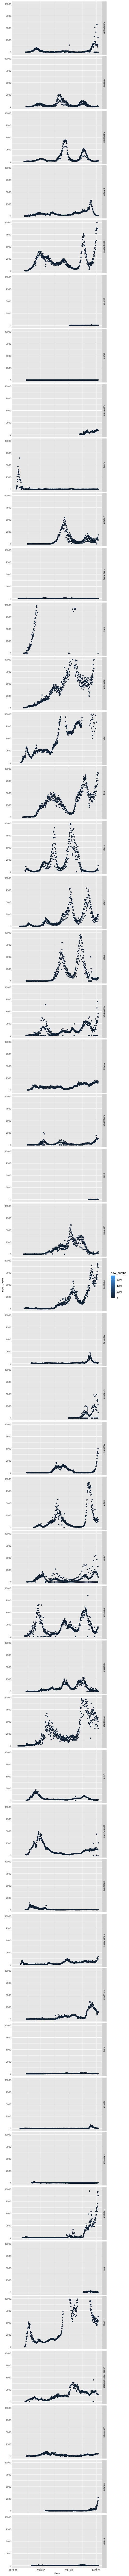

RObject{VecSxp}


In [13]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 500, :height => 10000))
R"""
options(warn=-1)
library(ggplot2)

ggplot($dfcases,aes(date,new_cases))+
  geom_point(aes(color=new_deaths))+ylim(0,10000)+
  facet_grid(location ~ .)
"""

In [14]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 700, :height => 300))

function plotdeaths(df::DataFrame,ctry::String)
  R"""
     options(warn=-1)
     library(ggplot2)
     ctr = $df %>% filter(location == $ctry)
     ggplot(ctr,aes(date,new_deaths))+
        geom_point(aes(color=new_deaths))+
        scale_x_date(date_breaks = "1 month", date_labels =  "%b %Y")+
        theme(axis.text.x=element_text(angle=60, hjust=1))
  """
end

function plotcases(df::DataFrame,ctry::String)
  R"""
     options(warn=-1)
     library(ggplot2)
     ctr = $df %>% filter(location == $ctry)
     ggplot(ctr,aes(date,new_cases))+
        geom_point(aes(color=new_cases))+
        scale_x_date(date_breaks = "1 month", date_labels =  "%b %Y")+
        theme(axis.text.x=element_text(angle=60, hjust=1))
  """
end
function covidplot(df,ctry)
    display(plotcases(df,ctry));
    display(plotdeaths(df,ctry));
end

covidplot (generic function with 1 method)

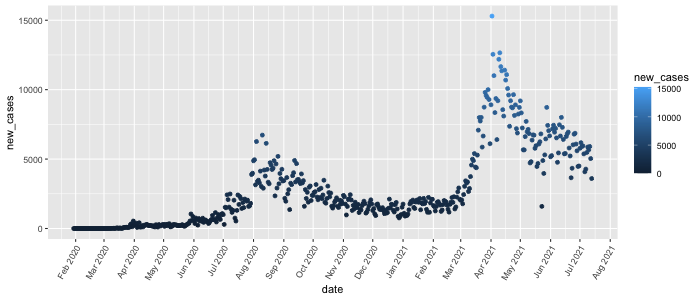

RObject{VecSxp}


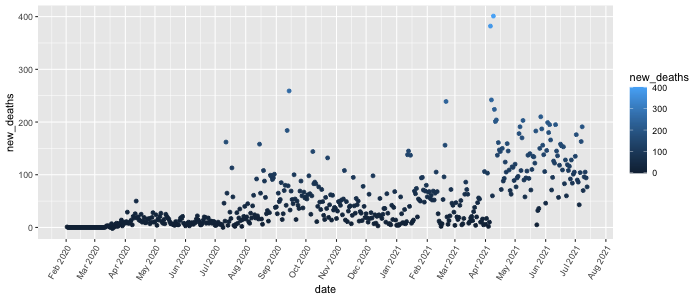

RObject{VecSxp}


In [15]:
covidplot(df,"Philippines")

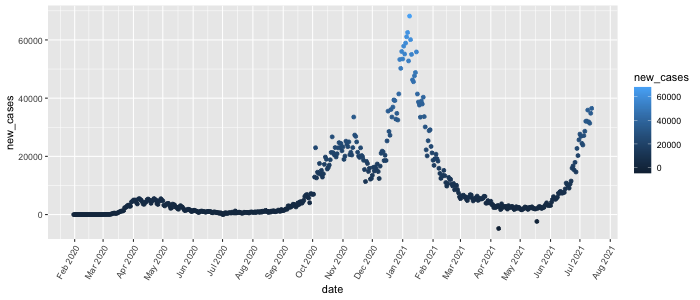

RObject{VecSxp}


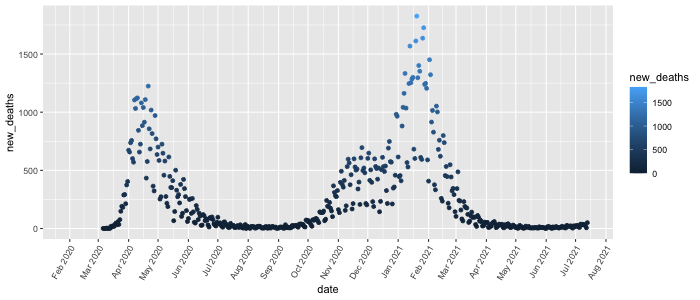

RObject{VecSxp}


In [16]:
covidplot(df,"United Kingdom")

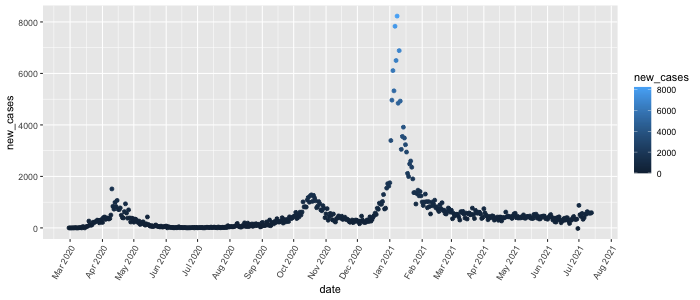

RObject{VecSxp}


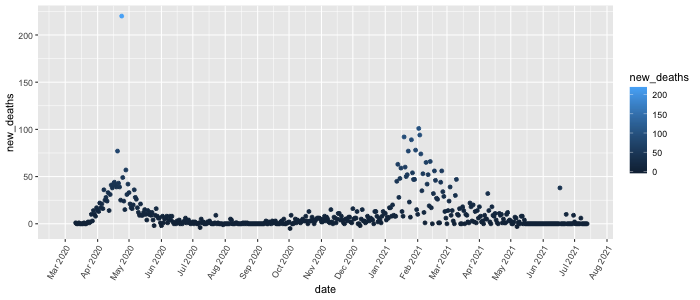

RObject{VecSxp}


In [17]:
covidplot(df,"Ireland")

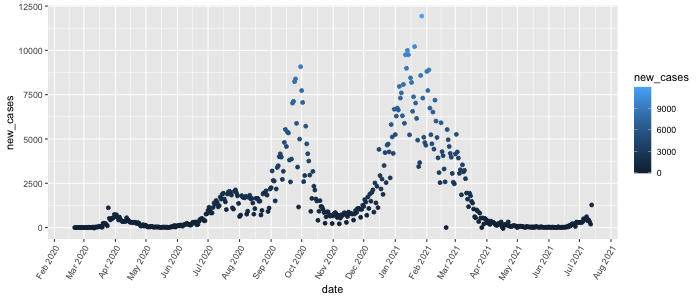

RObject{VecSxp}


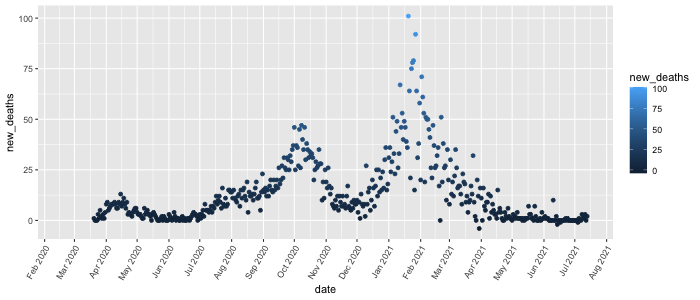

RObject{VecSxp}


In [18]:
covidplot(df,"Israel")

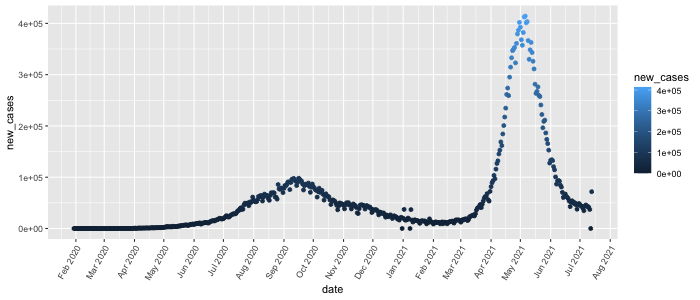

RObject{VecSxp}


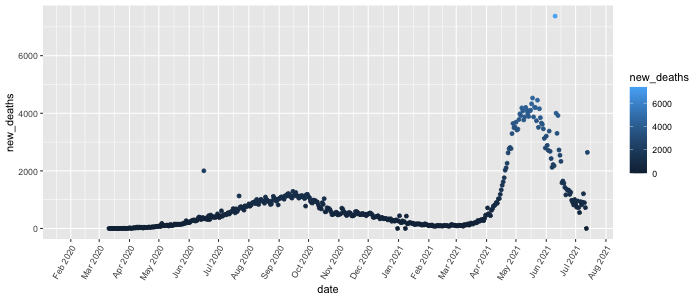

RObject{VecSxp}


In [19]:
covidplot(df,"India")

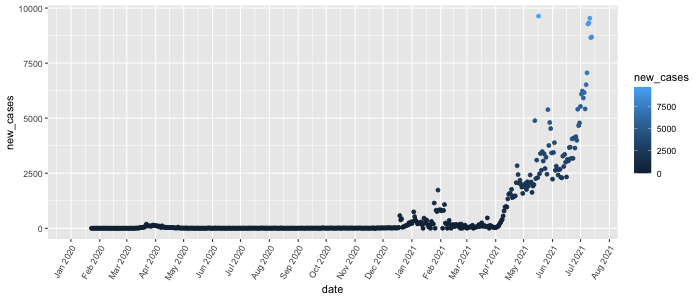

RObject{VecSxp}


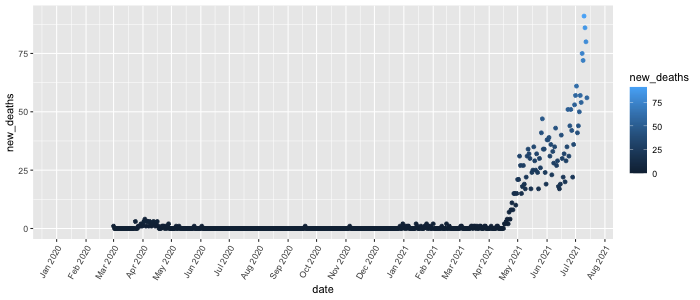

RObject{VecSxp}


In [20]:
covidplot(df,"Thailand")

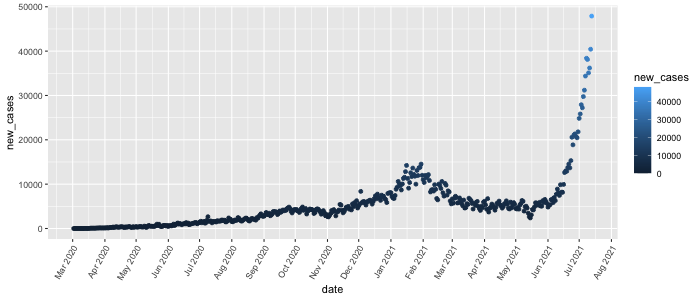

RObject{VecSxp}


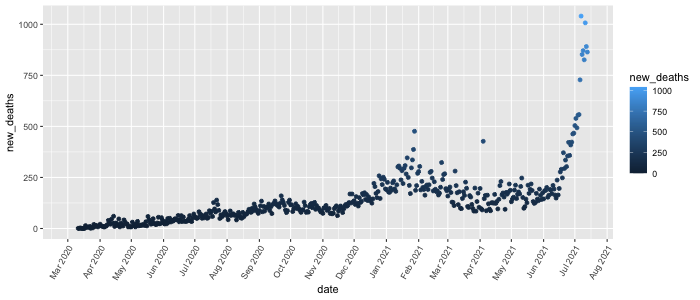

RObject{VecSxp}


In [21]:
covidplot(df,"Indonesia")

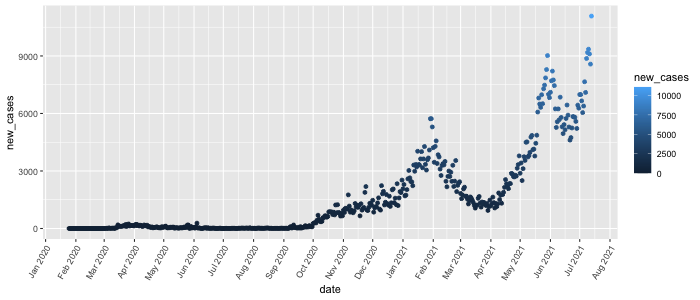

RObject{VecSxp}


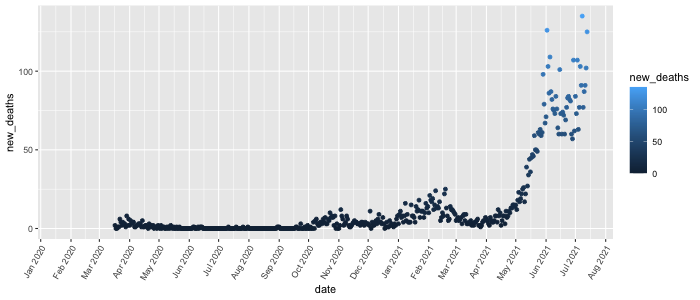

RObject{VecSxp}


In [22]:
covidplot(df,"Malaysia")

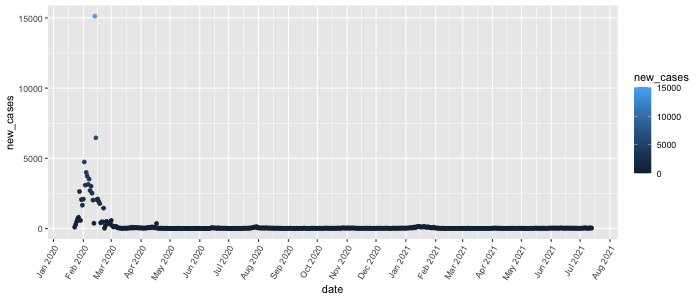

RObject{VecSxp}


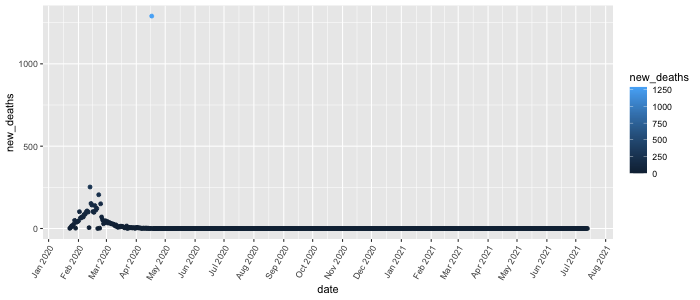

RObject{VecSxp}


In [23]:
covidplot(df,"China")

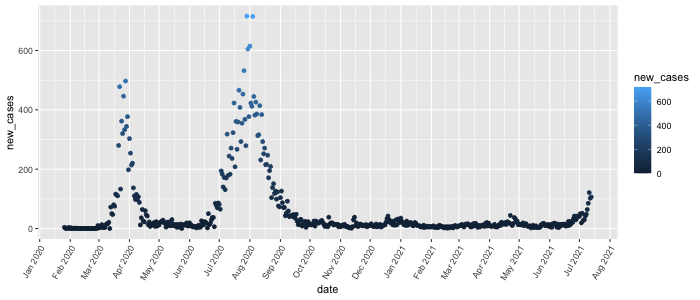

RObject{VecSxp}


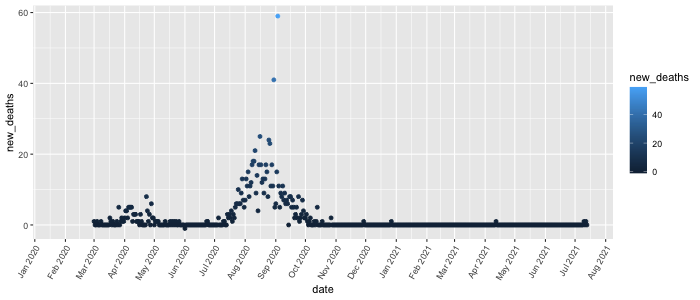

RObject{VecSxp}


In [24]:
covidplot(df,"Australia")

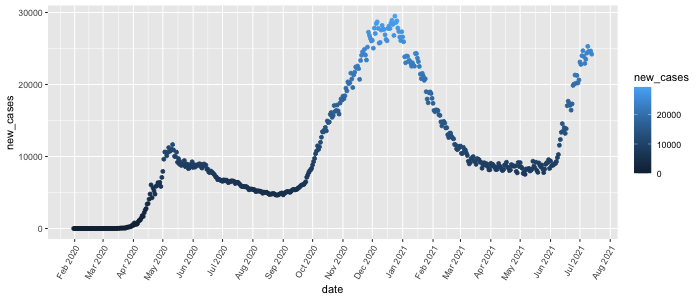

RObject{VecSxp}


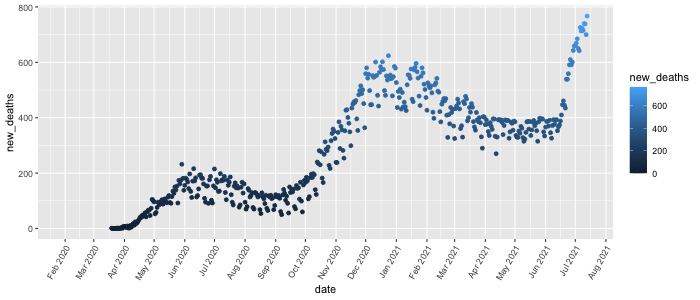

RObject{VecSxp}


In [25]:
covidplot(df,"Russia")

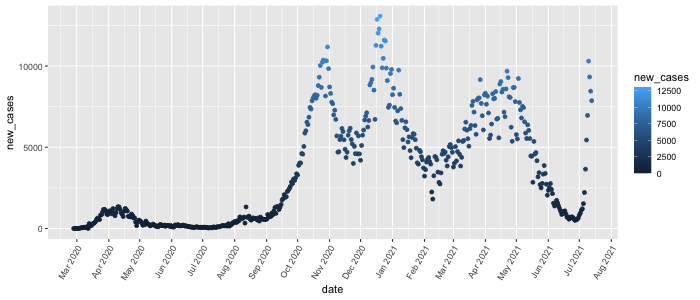

RObject{VecSxp}


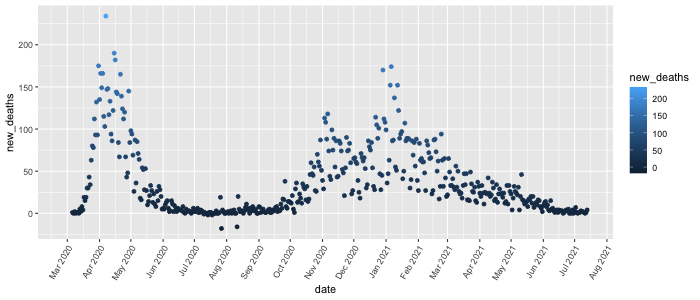

RObject{VecSxp}


In [26]:
covidplot(df,"Netherlands")

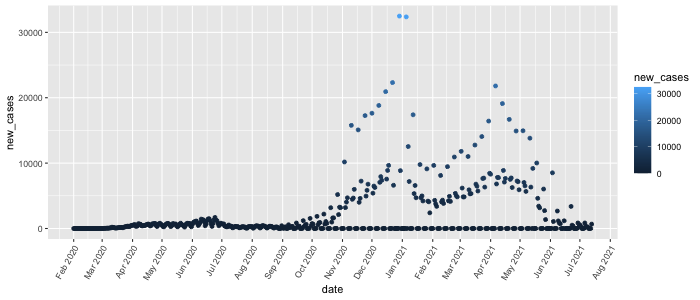

RObject{VecSxp}


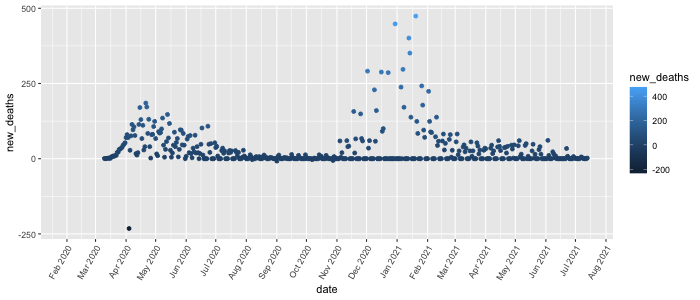

RObject{VecSxp}


In [27]:
covidplot(df,"Sweden")

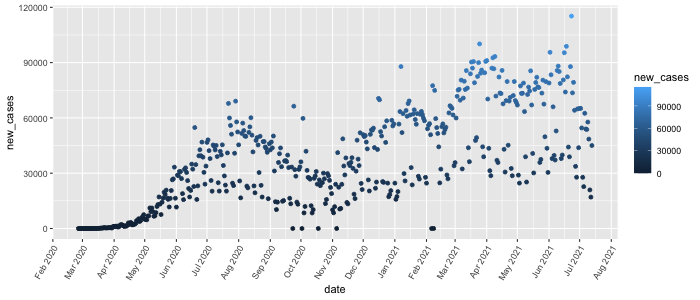

RObject{VecSxp}


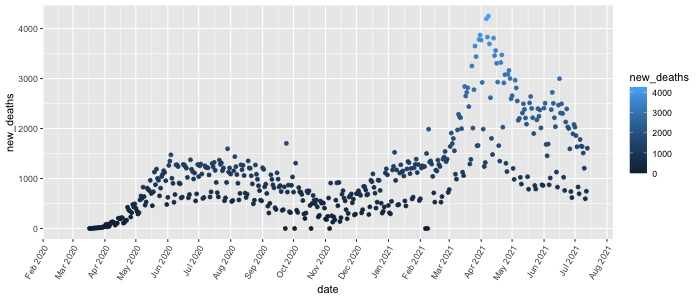

RObject{VecSxp}


In [28]:
covidplot(df,"Brazil")

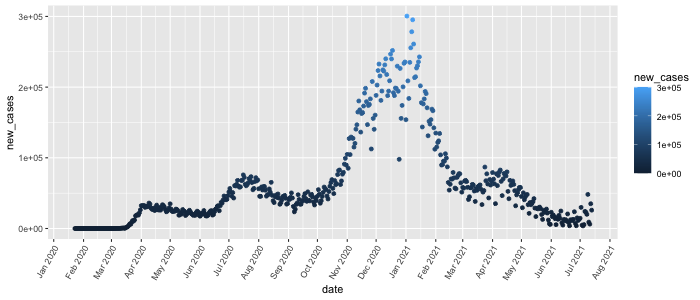

RObject{VecSxp}


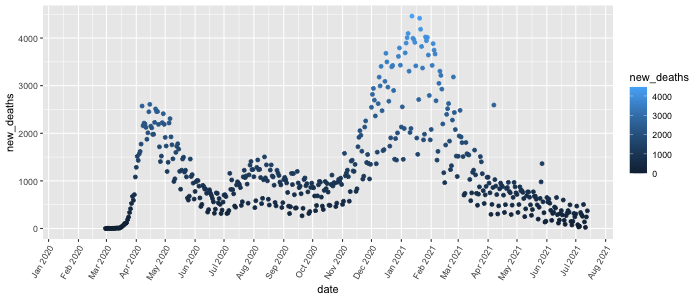

RObject{VecSxp}


In [29]:
covidplot(df,"United States")

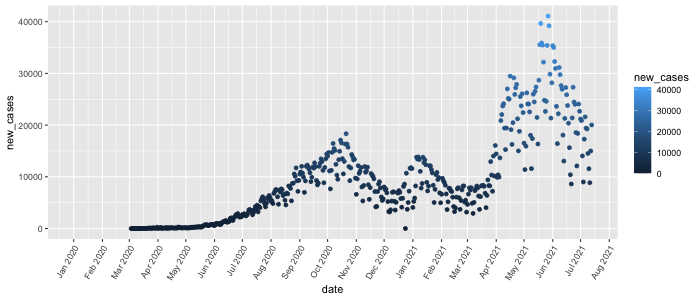

RObject{VecSxp}


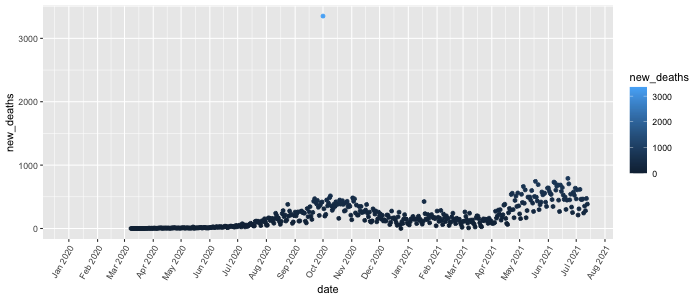

RObject{VecSxp}


In [30]:
covidplot(df,"Argentina")